<a href="https://colab.research.google.com/github/1289nav/visualisation-analysis-of-cnn-model-weights/blob/main/Visualization_and_analysis_of_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision

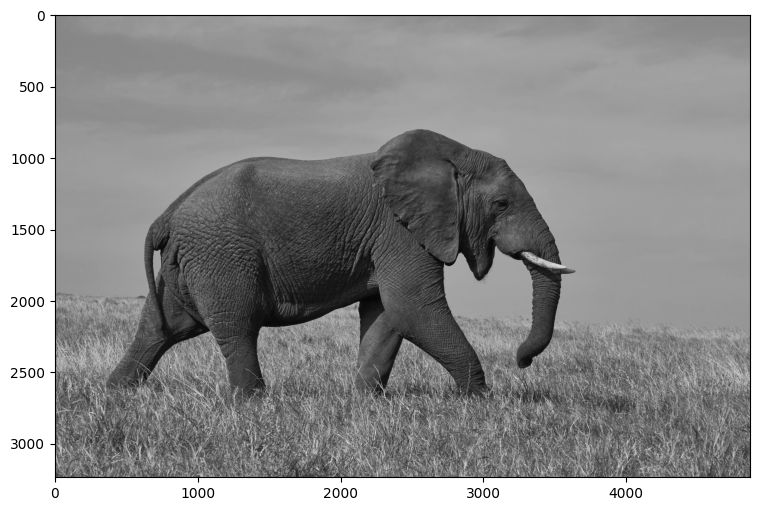

In [ ]:
import cv2
import matplotlib.pyplot as plt

# default figure size
plt.rcParams['figure.figsize'] = (12, 6)

# Select an image by file name
img_path = '/content/drive/MyDrive/AI Assignment/DSAI- SPR 2024/Assignment 1/wolfgang-hasselmann-P7L5011nD5s-unsplash.jpg'

# load color image
bgr_img = cv2.imread(img_path)
# convert to grayscale using OpenCV
gray_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)

gray_img = gray_img.astype("float32")/255

# plot image
plt.imshow(gray_img, cmap='gray')
plt.show()

# Part 1: Applying pre trained filters


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# define a neural network
class NeuralNet1(nn.Module):

    def __init__(self, weight):
        super(NeuralNet1, self).__init__()

        n_filters = 4
        self.conv = nn.Conv2d(2, n_filters, kernel_size=(21, 21),stride=1, bias=False)

        #nn.Conv2d()

        #Setting weights
        self.conv.weight = torch.nn.Parameter(weight)

        #Maxpooling layer
        self.pool = nn.MaxPool2d(2, 2)


    #Forward pass
    def forward(self, x):
        conv_x = self.conv(x)
        activated_x = F.relu(conv_x)
        pooled_x = self.pool(activated_x)

        return conv_x, activated_x, pooled_x

In [ ]:
#Defining the filters

#A) THE GAUSSIAN FILTER/GAUSSIAN BLUR FILTER

#This filter is used for blurring images
size=21
sigma=10.0
g_kernel_1d = cv2.getGaussianKernel(size, sigma)

#cv2 get gaussian kernel function return a 1D filter, need a 2d matrix filter. so outer product is performed
gaussian_filter=np.outer(g_kernel_1d,g_kernel_1d)

#print("Gaussian filter defined is: :", gaussian_filter)

#B) LAPLACIAN FILTER

#We use a positive laplacian filter
#This filter is used to to detect edges
#We create a function to approximate the 2nd order derivatives

def create_laplacian_kernel(s):
    kernel = np.zeros((s, s), dtype=np.float32)
    center = size // 2

    for i in range(s):
        for j in range(s):
            kernel[i, j] = -1 if (i == center and j == center) else 0

    kernel[center, center] = s**2 - 1

    return kernel

laplace_filter = create_laplacian_kernel(size)
#print("Laplace filter is defined as: ", laplace_filter)

#C) Sobel Filter

#Computing n sized sobel kernel
def sobel_kernel(k):
  kern=np.zeros((k,k),dtype=np.float32)

  for i in range(k):
    for j in range(k):
      x=i-(k//2)
      y=j-(k//2)
      if(x==0 & y==0):
        kern[i,j]=y

      else:
        kern[i,j]=y/(x**2+y**2)

  return kern
sobel_x_dupli=sobel_kernel(size)
sobel_y=sobel_x_dupli.T

filters = np.array([gaussian_filter,laplace_filter,sobel_x_dupli,sobel_y])

In [ ]:
#Instantiating model weights to our found filters
weight = torch.from_numpy(filters).unsqueeze(1).type(torch.FloatTensor)
model = NeuralNet1(weight)

# print out the layers in the network
print(model)

NeuralNet1(
  (conv): Conv2d(2, 4, kernel_size=(21, 21), stride=(1, 1), bias=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# helper files for displaying images

# helper function for visualizing the output of a given layer
def viz_layer(layer, n_filters= 4):
    fig = plt.figure(figsize=(20, 20))

    for i in range(n_filters):
        ax = fig.add_subplot(1, n_filters, i+1)
        # grab layer outputs
        ax.imshow(np.squeeze(layer[0,i].data.numpy()), cmap='gray')
        ax.set_title('Output %s' % str(i+1))


# plot given filters as small images in a row
def plot_filters(filters):
    n_filters = len(filters)
    fig = plt.figure(figsize=(12, 6))
    fig.subplots_adjust(left=0, right=1.5, bottom=0.8, top=1, hspace=0.05, wspace=0.05)
    for i in range(n_filters):
        ax = fig.add_subplot(1, n_filters, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i], cmap='gray')
        ax.set_title('Filter %s' % str(i+1))

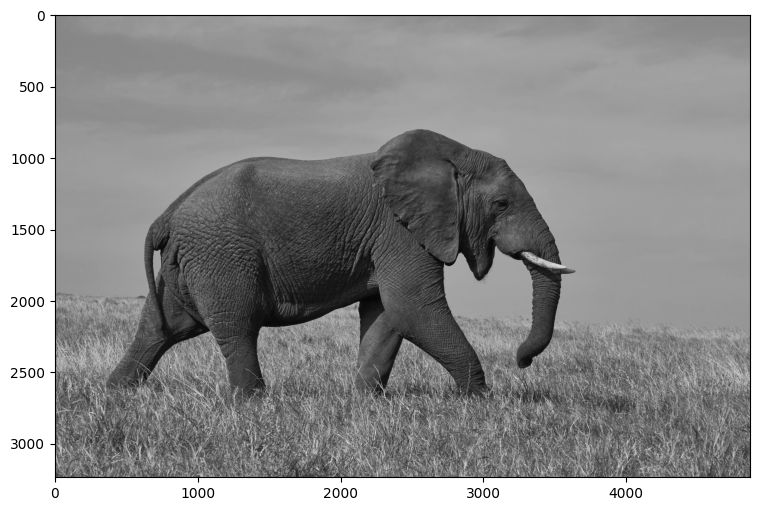

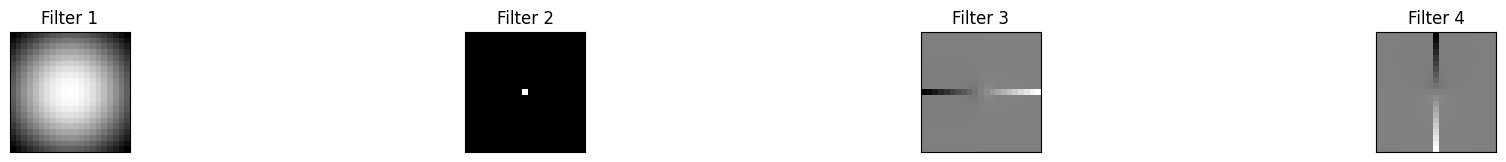

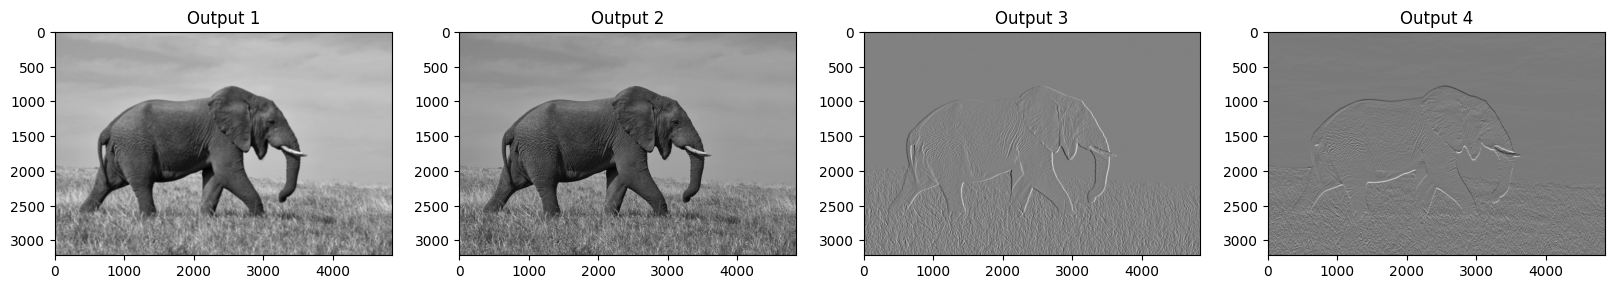

In [ ]:
# plot original image
plt.imshow(gray_img, cmap='gray')

# plot all the filters in a row
plot_filters(filters)

# convert the grayscale image into an input Tensor
gray_img_tensor = torch.from_numpy(gray_img).unsqueeze(0).unsqueeze(1)

# get all the layers from the forwrad function of our model
# with a call to `model(input)`
conv_layer, activated_layer, pooled_layer = model(gray_img_tensor)

# visualize the output of the convolutional layer
viz_layer(conv_layer)

# Part 2: Training CNN filters- MNIST Dataset

In [ ]:
import torch
import torchvision

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import torchvision.transforms as transforms

from torchsummary import summary

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF



In [ ]:
use_cuda = torch.cuda.is_available()
print('Using PyTorch version:', torch.__version__, 'CUDA:', use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")
print("Device in Use:",device)

Using PyTorch version: 2.1.0+cu121 CUDA: False
Device in Use: cpu


In [ ]:
BATCH_SIZE = 32

transform = transforms.Compose(
    [transforms.ToTensor(),])

# download and load train
train_MNIST = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_MNIST, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

# download and load test
test_MNIST = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(test_MNIST, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

100%|██████████| 9912422/9912422 [00:00<00:00, 104354609.46it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 30397915.64it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 24502194.45it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14018049.13it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
print(train_MNIST)
print(test_MNIST)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [ ]:
# define a neural network
class NeuralNet_MNIST_1(nn.Module):

    def __init__(self, weight):
        super(NeuralNet_MNIST_1, self).__init__()

        n_filters = 3
        self.conv = nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=3, stride=1, padding=1, bias=False)
        #nn.Conv2d()
        #Setting weights
        self.conv.weight = torch.nn.Parameter(weight)

        #Maxpooling layer
        self.pool = nn.MaxPool2d(2, 2)

        #Output layer- 10 classes to output
        self.out=nn.Linear(3*14*14,10,bias=False)


    #Forward pass
    def forward(self, x):
        conv_x = self.conv(x)
        activated_x = F.relu(conv_x)
        x = self.pool(activated_x)

        x = x.view(x.size(0), -1)

        logits = self.out(x)

        return logits

In [ ]:
#Instantiating weights to a random vector
np.random.seed(38)
filter_1=np.random.rand(3,3)
filter_2=np.random.rand(3,3)
filter_3=np.random.rand(3,3)

MNIST_Filter=np.array([filter_1,filter_2,filter_3])
weight_MNIST = torch.from_numpy(MNIST_Filter).unsqueeze(1).type(torch.FloatTensor)
MNIST_NN= NeuralNet_MNIST_1(weight_MNIST)

# print out the layers in the network
print(MNIST_NN)

NeuralNet_MNIST_1(
  (conv): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (out): Linear(in_features=588, out_features=10, bias=False)
)


In [ ]:
for images, labels in trainloader:
    print("batch size:", images.shape)
    out = MNIST_NN(images)
    print(out.shape)
    break

batch size: torch.Size([32, 1, 28, 28])
torch.Size([32, 10])


In [ ]:
summary(MNIST_NN, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 28, 28]              27
         MaxPool2d-2            [-1, 3, 14, 14]               0
            Linear-3                   [-1, 10]           5,880
Total params: 5,907
Trainable params: 5,907
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.02
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


In [ ]:
#Loss function
loss_func = nn.CrossEntropyLoss(reduction='none')

#Optimizer Function
from torch import optim
optimizer = optim.Adam(MNIST_NN.parameters(), lr = 0.01)

In [ ]:
num_epochs = 10
model = MNIST_NN.to(device)

In [ ]:
def get_accuracy(output, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(output, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [ ]:
#MODEL TRAINING
for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0

    model = model.train()

    #Trainig step
    for i, (images, labels) in enumerate(trainloader):

        images = images.to(device)
        labels = labels.to(device)


        predictions = model(images)
        loss = loss_func(predictions, labels)
        optimizer.zero_grad()
        loss.sum().backward()

        optimizer.step()

        train_loss += loss.detach().mean().item()
        train_acc += get_accuracy(predictions, labels, BATCH_SIZE)

    model.eval()
    print("Epoch: ",epoch,"|Loss: ",train_loss/i,"| Train Accuraccy: ",train_acc/i)

Epoch:  0 |Loss:  0.3017300750156755 | Train Accuraccy:  91.19697171824973
Epoch:  1 |Loss:  0.14586676883420796 | Train Accuraccy:  95.66435432230523
Epoch:  2 |Loss:  0.12528497822311377 | Train Accuraccy:  96.22131803628602
Epoch:  3 |Loss:  0.11645016130176745 | Train Accuraccy:  96.54148879402348
Epoch:  4 |Loss:  0.10969655728756561 | Train Accuraccy:  96.70657684098185
Epoch:  5 |Loss:  0.10368533904754668 | Train Accuraccy:  96.99339647812167
Epoch:  6 |Loss:  0.09941140093721137 | Train Accuraccy:  97.01674226254002
Epoch:  7 |Loss:  0.09863786865643866 | Train Accuraccy:  97.01007203842049
Epoch:  8 |Loss:  0.09461960318019855 | Train Accuraccy:  97.2201840981857
Epoch:  9 |Loss:  0.09424006201989309 | Train Accuraccy:  97.19016808964781


# Part 3 and 4: Varying sizes of Filters


**CONVOLUTION AND POOLING FORMULA**

N=((M+2P-R)/S)+1

where

N= Size of output

M= Size of input

P= Padding

R= Kernel size

S= Stride


## Kernel size 5

CONV 2D: M=28, P=2, R=5, S=1

N=28

POOL 2D: M=28, P=0, R=2, S=2
N=14

In [ ]:
# define a neural network
class NeuralNet_MNIST_2(nn.Module):

    def __init__(self, weight):
        super(NeuralNet_MNIST_2, self).__init__()

        n_filters = 3
        self.conv = nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=5, stride=1, padding=2, bias=False)
        #nn.Conv2d()
        #Setting weights
        self.conv.weight = torch.nn.Parameter(weight)

        #Maxpooling layer
        self.pool = nn.MaxPool2d(2, 2)

        #Output layer- 10 classes to output
        self.out=nn.Linear(3*14*14,10,bias=False)


    #Forward pass
    def forward(self, x):
        conv_x = self.conv(x)
        activated_x = F.relu(conv_x)
        x = self.pool(activated_x)

        x = x.view(x.size(0), -1)

        logits = self.out(x)

        return logits

In [ ]:
#Instantiating weights to a random vector
np.random.seed(38)
filter_1_5=np.random.rand(5,5)
filter_2_5=np.random.rand(5,5)
filter_3_5=np.random.rand(5,5)

MNIST_Filter_5=np.array([filter_1_5,filter_2_5,filter_3_5])
weight_MNIST_5 = torch.from_numpy(MNIST_Filter_5).unsqueeze(1).type(torch.FloatTensor)
MNIST_NN_5= NeuralNet_MNIST_2(weight_MNIST_5)

# print out the layers in the network
print(MNIST_NN_5)

NeuralNet_MNIST_2(
  (conv): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (out): Linear(in_features=588, out_features=10, bias=False)
)


In [ ]:
summary(MNIST_NN_5, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 28, 28]              75
         MaxPool2d-2            [-1, 3, 14, 14]               0
            Linear-3                   [-1, 10]           5,880
Total params: 5,955
Trainable params: 5,955
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.02
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


In [ ]:
num_epochs_new = 4
model_5 = MNIST_NN_5.to(device)

In [ ]:
#MODEL TRAINING
for epoch in range(num_epochs_new):
    train_loss = 0.0
    train_acc = 0.0

    model_5 = model_5.train()

    #Trainig step
    for i, (images, labels) in enumerate(trainloader):

        images = images.to(device)
        labels = labels.to(device)


        predictions = model_5(images)
        loss = loss_func(predictions, labels)
        optimizer.zero_grad()
        loss.sum().backward()

        optimizer.step()

        train_loss += loss.detach().mean().item()
        train_acc += get_accuracy(predictions, labels, BATCH_SIZE)

    model.eval()
    print("Epoch: ",epoch,"|Loss: ",train_loss/i,"| Train Accuraccy: ",train_acc/i)

Epoch:  0 |Loss:  3.972909123691449 | Train Accuraccy:  10.29715848452508
Epoch:  1 |Loss:  3.97290912458202 | Train Accuraccy:  10.29715848452508
Epoch:  2 |Loss:  3.9729091273809574 | Train Accuraccy:  10.29715848452508
Epoch:  3 |Loss:  3.9729091211469605 | Train Accuraccy:  10.29715848452508


## Kernel Size 7

In [ ]:
# define a neural network
class NeuralNet_MNIST_3(nn.Module):

    def __init__(self, weight):
        super(NeuralNet_MNIST_3, self).__init__()

        n_filters = 3
        self.conv = nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=7, stride=1, padding=3, bias=False)
        #nn.Conv2d()
        #Setting weights
        self.conv.weight = torch.nn.Parameter(weight)

        #Maxpooling layer
        self.pool = nn.MaxPool2d(2, 2)

        #Output layer- 10 classes to output
        self.out=nn.Linear(3*14*14,10,bias=False)


    #Forward pass
    def forward(self, x):
        conv_x = self.conv(x)
        activated_x = F.relu(conv_x)
        x = self.pool(activated_x)

        x = x.view(x.size(0), -1)

        logits = self.out(x)

        return logits

In [ ]:
#Instantiating weights to a random vector
np.random.seed(38)
filter_1_7=np.random.rand(7,7)
filter_2_7=np.random.rand(7,7)
filter_3_7=np.random.rand(7,7)

MNIST_Filter_7=np.array([filter_1_7,filter_2_7,filter_3_7])
weight_MNIST_7 = torch.from_numpy(MNIST_Filter_7).unsqueeze(1).type(torch.FloatTensor)
MNIST_NN_7= NeuralNet_MNIST_3(weight_MNIST_7)

# print out the layers in the network
print(MNIST_NN_7)

NeuralNet_MNIST_3(
  (conv): Conv2d(1, 3, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (out): Linear(in_features=588, out_features=10, bias=False)
)


In [ ]:
summary(MNIST_NN_7, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 28, 28]             147
         MaxPool2d-2            [-1, 3, 14, 14]               0
            Linear-3                   [-1, 10]           5,880
Total params: 6,027
Trainable params: 6,027
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.02
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


In [ ]:
model_7 = MNIST_NN_7.to(device)

In [ ]:
#MODEL TRAINING
for epoch in range(num_epochs_new):
    train_loss = 0.0
    train_acc = 0.0

    model_5 = model_5.train()

    #Trainig step
    for i, (images, labels) in enumerate(trainloader):

        images = images.to(device)
        labels = labels.to(device)


        predictions = model_5(images)
        loss = loss_func(predictions, labels)
        optimizer.zero_grad()
        loss.sum().backward()

        optimizer.step()

        train_loss += loss.detach().mean().item()
        train_acc += get_accuracy(predictions, labels, BATCH_SIZE)

    model.eval()
    print("Epoch: ",epoch,"|Loss: ",train_loss/i,"| Train Accuraccy: ",train_acc/i)

Epoch:  0 |Loss:  3.9729091173302273 | Train Accuraccy:  10.29715848452508
Epoch:  1 |Loss:  3.9729091247092443 | Train Accuraccy:  10.29715848452508
Epoch:  2 |Loss:  3.972909120129165 | Train Accuraccy:  10.29715848452508
Epoch:  3 |Loss:  3.9729091297982215 | Train Accuraccy:  10.29715848452508


# Part 4: Stride on filters

In [ ]:
class NeuralNet2(nn.Module):

    def __init__(self, weight):
        super(NeuralNet2, self).__init__()

        n_filters = 4
        self.conv = nn.Conv2d(2, n_filters, kernel_size=(21, 21),stride=1, padding= 10, bias=False)

        #nn.Conv2d()

        #Setting weights
        self.conv.weight = torch.nn.Parameter(weight)

        #Maxpooling layer
        self.pool = nn.MaxPool2d(2, 2)


    #Forward pass
    def forward(self, x):
        conv_x = self.conv(x)
        activated_x = F.relu(conv_x)
        pooled_x = self.pool(activated_x)

        return conv_x, activated_x, pooled_x

In [ ]:
#Instantiating model weights to our found filters
weight = torch.from_numpy(filters).unsqueeze(1).type(torch.FloatTensor)
modelnew = NeuralNet2(weight)

# print out the layers in the network
print(model)

NeuralNet1(
  (conv): Conv2d(2, 4, kernel_size=(21, 21), stride=(1, 1), bias=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


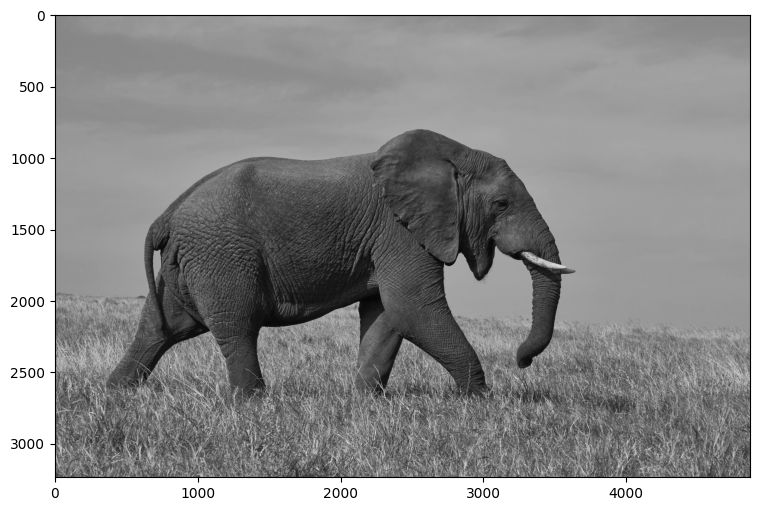

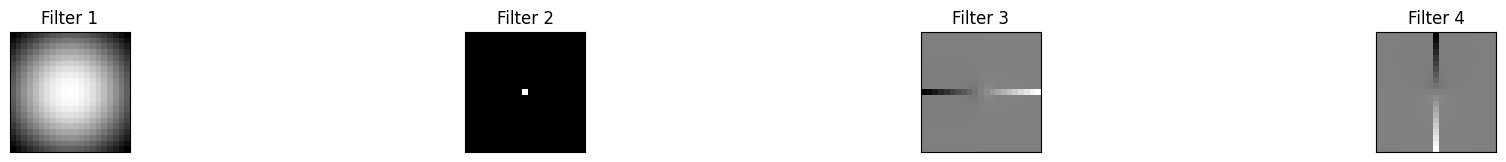

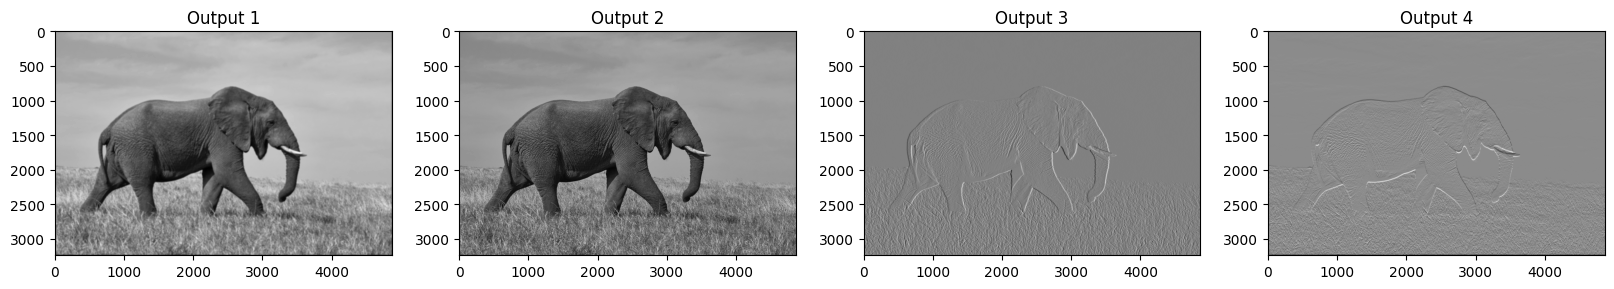

In [ ]:
# plot original image
plt.imshow(gray_img, cmap='gray')

# plot all the filters in a row
plot_filters(filters)

# convert the grayscale image into an input Tensor
gray_img_tensor = torch.from_numpy(gray_img).unsqueeze(0).unsqueeze(1)

# get all the layers from the forwrad function of our model
# with a call to `model(input)`
conv_layer, activated_layer, pooled_layer = modelnew(gray_img_tensor)

# visualize the output of the convolutional layer
viz_layer(conv_layer)

# Part 5: Max min and Avg pooling options

In [ ]:
class NeuralNet3(nn.Module):

    def __init__(self, weight):
        super(NeuralNet3, self).__init__()

        n_filters = 4
        self.conv = nn.Conv2d(2, n_filters, kernel_size=(21, 21),stride=1, padding= 10, bias=False)

        #nn.Conv2d()

        #Setting weights
        self.conv.weight = torch.nn.Parameter(weight)

        #Maxpooling layer
        self.pool1 = nn.MaxPool2d(5, 2)

        #Average pool layer
        self.pool2 = nn.AvgPool2d(5, 2)

        #Minimum pooling layer
        self.pool3=nn.MaxPool2d(5,2)

    #Forward pass
    def forward(self, x):
        conv_x = self.conv(x)
        activated_x = F.relu(conv_x)
        pooled_max_x = self.pool1(activated_x)
        pooled_avg_x=self.pool2(activated_x)
        pooled_min_x=-self.pool3(-activated_x)

        return conv_x, activated_x, pooled_max_x, pooled_avg_x, pooled_min_x

In [ ]:
#Instantiating model weights to our found filters
weight = torch.from_numpy(filters).unsqueeze(1).type(torch.FloatTensor)
modelnew2 = NeuralNet3(weight)

# print out the layers in the network
print(modelnew2)

NeuralNet3(
  (conv): Conv2d(2, 4, kernel_size=(21, 21), stride=(1, 1), padding=(10, 10), bias=False)
  (pool1): MaxPool2d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): AvgPool2d(kernel_size=5, stride=2, padding=0)
  (pool3): MaxPool2d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
)


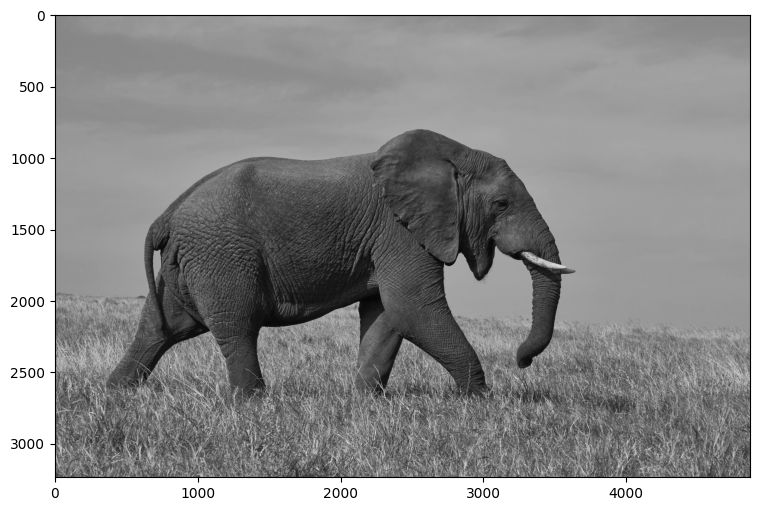

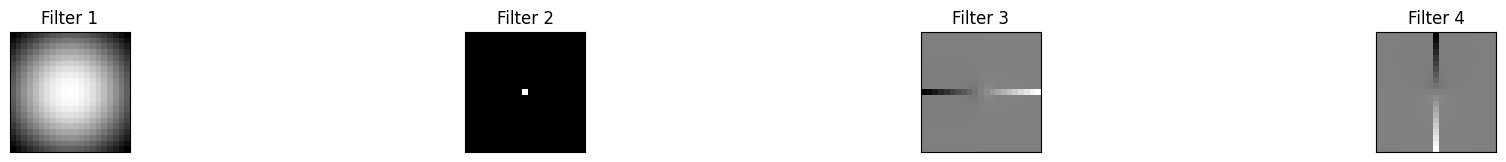

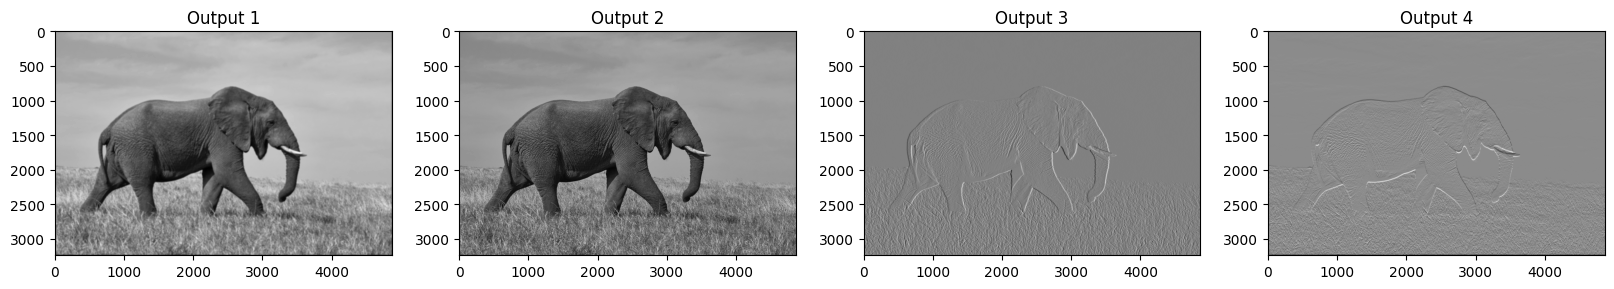

In [ ]:
# plot original image
plt.imshow(gray_img, cmap='gray')

# plot all the filters in a row
plot_filters(filters)

# convert the grayscale image into an input Tensor
gray_img_tensor = torch.from_numpy(gray_img).unsqueeze(0).unsqueeze(1)

# get all the layers from the forwrad function of our model
# with a call to `model(input)`
conv_layer_new, activated_layer_new, pooled_layer_1_new, pooled_layer_2_new, pooled_layer_3_new = modelnew2(gray_img_tensor)

# visualize the output of the convolutional layer
viz_layer(conv_layer_new)

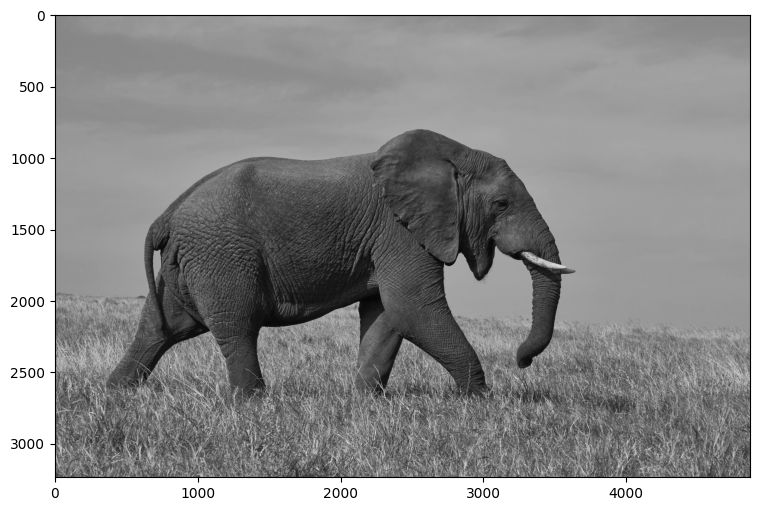

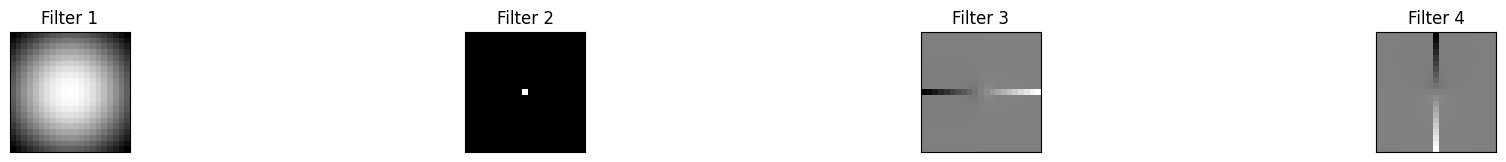

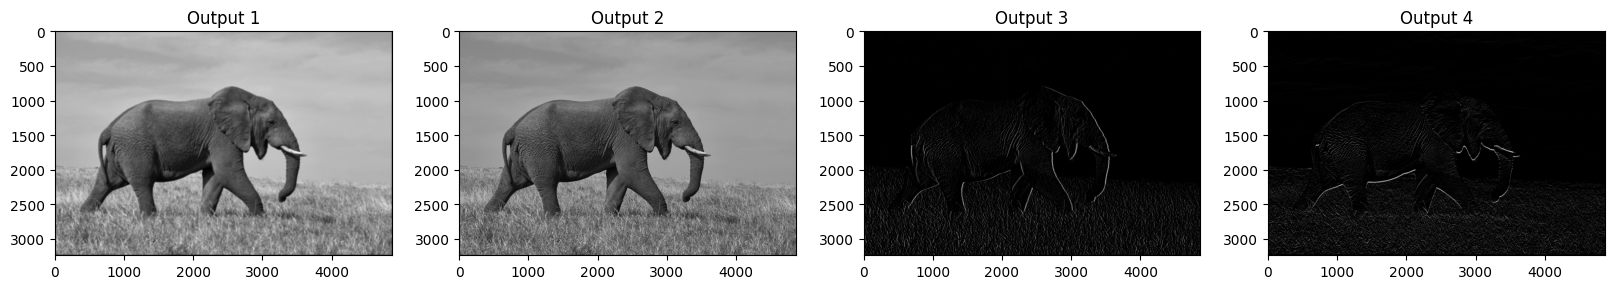

In [ ]:
# plot original image
plt.imshow(gray_img, cmap='gray')
# plot all the filters in a row
plot_filters(filters)

# visualize the output of the *activated* convolutional layer
viz_layer(activated_layer_new)

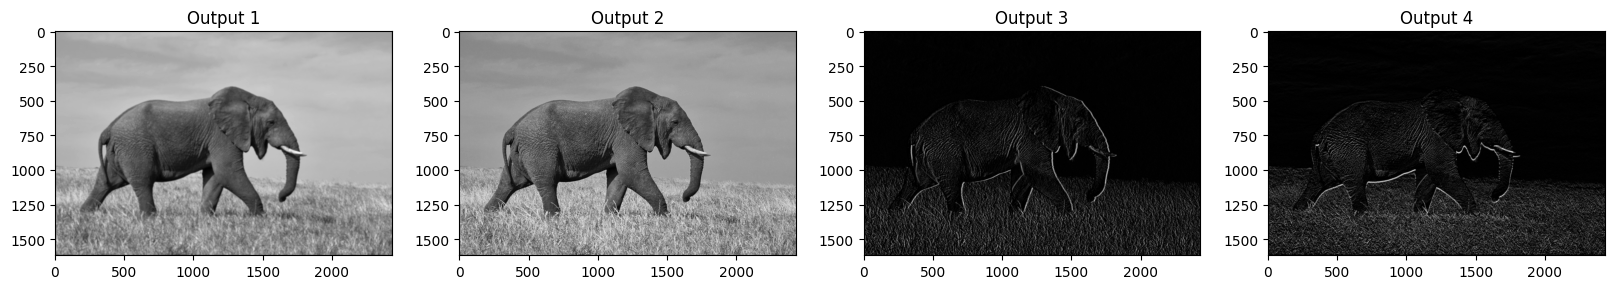

In [ ]:
# visualize the output of the pooling layer
viz_layer(pooled_layer_1_new)

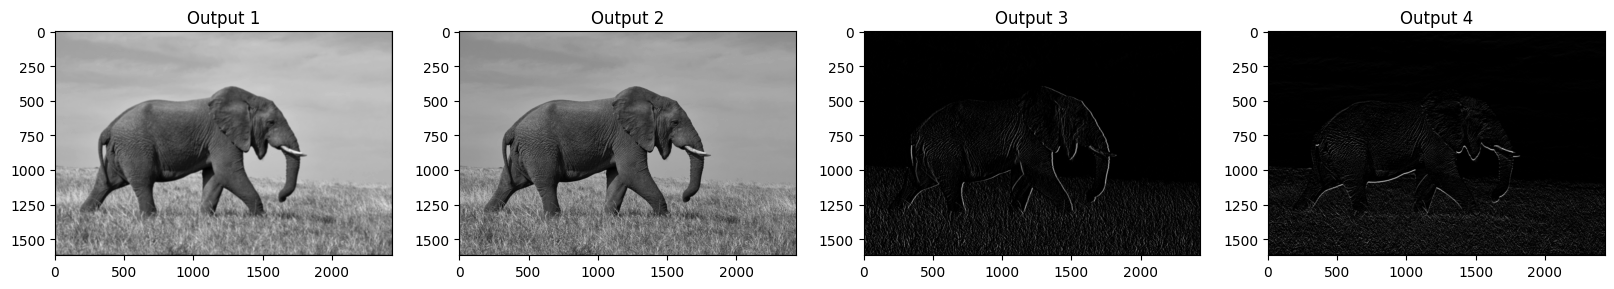

In [ ]:
# visualize the output of the pooling layer
viz_layer(pooled_layer_2_new)

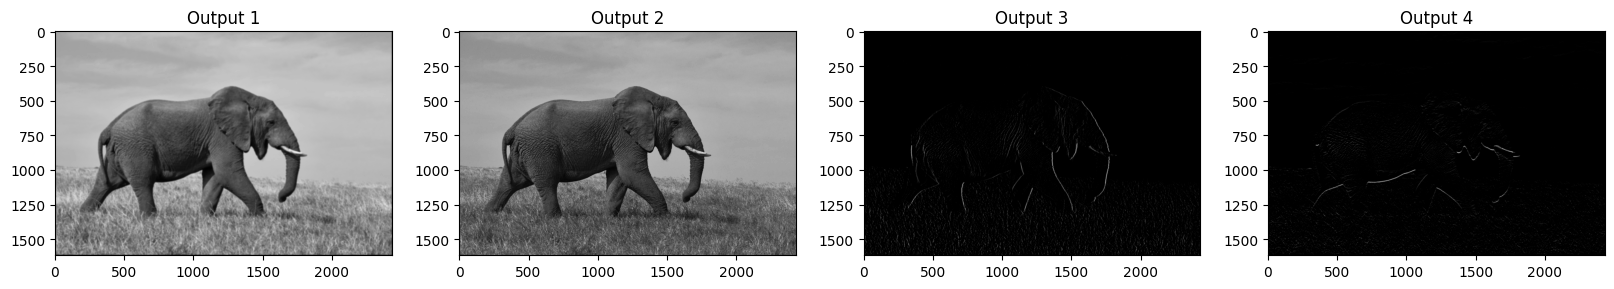

In [ ]:
# visualize the output of the pooling layer
viz_layer(pooled_layer_3_new)

# Part 6: Visualizing Filters of VGG 16 and applying to new image

In [ ]:
 # linear algebra
import tensorflow as tf

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
from matplotlib import pyplot

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Load the model

vgg16_mod = VGG16()

# Summary of the model
vgg16_mod.summary()

553467096/553467096 [==============================] - 11s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [ ]:
for layer in vgg16_mod.layers:

    if 'conv' not in layer.name:
        continue
    filters , bias = layer.get_weights()
    print(layer.name , filters.shape)

block1_conv1 (3, 3, 3, 64)
block1_conv2 (3, 3, 64, 64)
block2_conv1 (3, 3, 64, 128)
block2_conv2 (3, 3, 128, 128)
block3_conv1 (3, 3, 128, 256)
block3_conv2 (3, 3, 256, 256)
block3_conv3 (3, 3, 256, 256)
block4_conv1 (3, 3, 256, 512)
block4_conv2 (3, 3, 512, 512)
block4_conv3 (3, 3, 512, 512)
block5_conv1 (3, 3, 512, 512)
block5_conv2 (3, 3, 512, 512)
block5_conv3 (3, 3, 512, 512)


In [ ]:
# retrieve weights from the second hidden layer
filters , bias = vgg16_mod.layers[1].get_weights()

In [ ]:
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

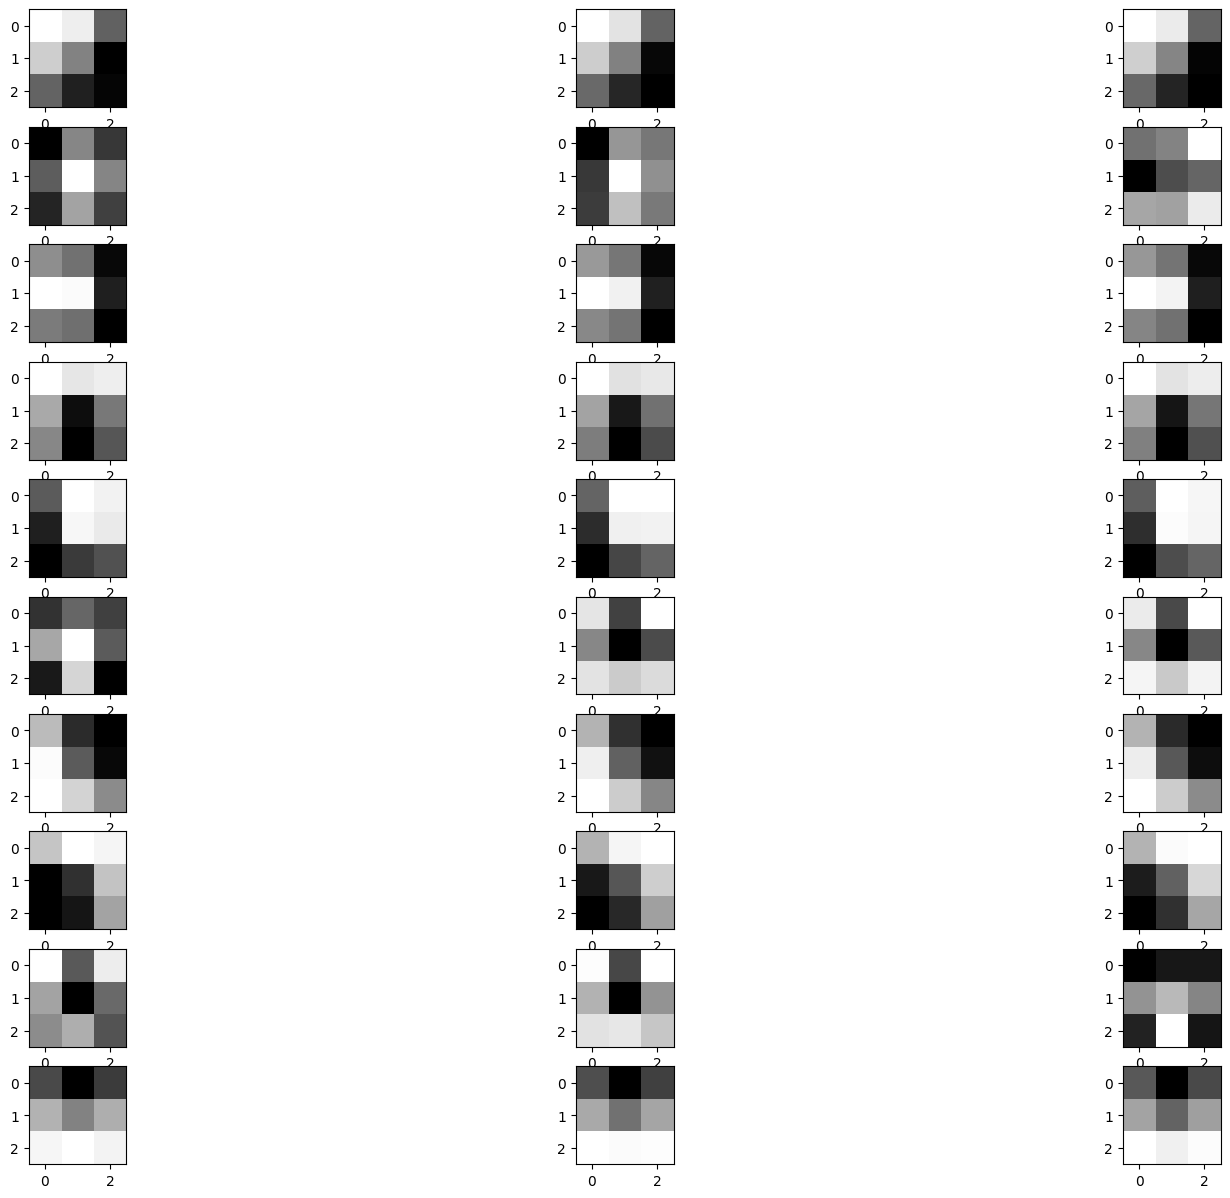

In [ ]:
n_filters =10
ix=1
fig = pyplot.figure(figsize=(20,15))
for i in range(n_filters):
    # get the filters
    f = filters[:,:,:,i]
    for j in range(3):
        # subplot for 10 filters and 3 channels
        pyplot.subplot(n_filters,3,ix)
        pyplot.imshow(f[:,:,j] ,cmap='gray')
        ix+=1
#plot the filters
pyplot.show()

In [ ]:
i=0
for layer in vgg16_mod.layers:
    i=i+1
    if 'conv' not in layer.name:
        continue
    print(i , layer.name , layer.output.shape)


2 block1_conv1 (None, 224, 224, 64)
3 block1_conv2 (None, 224, 224, 64)
5 block2_conv1 (None, 112, 112, 128)
6 block2_conv2 (None, 112, 112, 128)
8 block3_conv1 (None, 56, 56, 256)
9 block3_conv2 (None, 56, 56, 256)
10 block3_conv3 (None, 56, 56, 256)
12 block4_conv1 (None, 28, 28, 512)
13 block4_conv2 (None, 28, 28, 512)
14 block4_conv3 (None, 28, 28, 512)
16 block5_conv1 (None, 14, 14, 512)
17 block5_conv2 (None, 14, 14, 512)
18 block5_conv3 (None, 14, 14, 512)


In [ ]:
new_model = Model(inputs=vgg16_mod.inputs , outputs=vgg16_mod.layers[1].output)

In [ ]:
print(new_model.inputs)

[<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>]


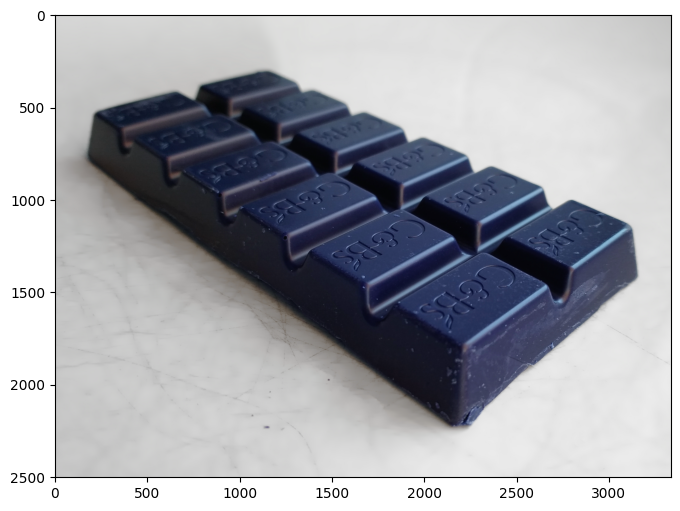

In [ ]:
#Image path with image of a
new_img_path = '/content/drive/MyDrive/AI Assignment/DSAI- SPR 2024/Assignment 1/Green_and_Blacks_dark_chocolate_bar_2.jpg'
new_img=cv2.imread(new_img_path)
plt.imshow(new_img,cmap='plasma')
plt.show()

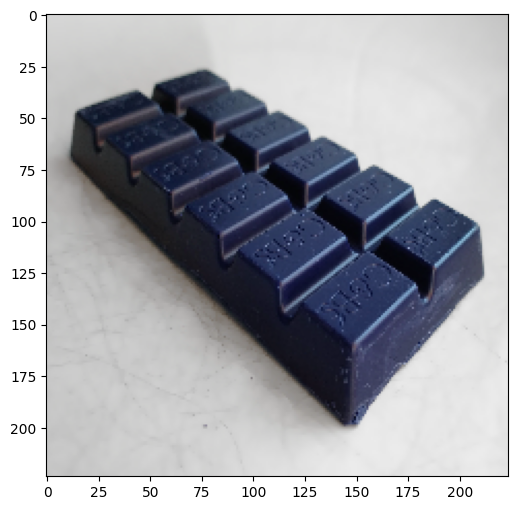

In [ ]:
#We now resize the image to preferred dimensions of VGG model which is 224,224
# Specify the new dimensions (width, height)
new_width = 224
new_height = 224

# Resize the image using cv2.resize
new_img = cv2.resize(new_img, (new_width, new_height))

plt.imshow(new_img,cmap='plasma')
plt.show()

In [ ]:
#Converting the image to a numpy array
new_img=img_to_array(new_img)
print(new_img.dtype)

# expand dimensions so that it represents a single 'sample'
new_img = expand_dims(new_img, axis=0)
print(new_img.dtype)

float32
float32


In [ ]:
new_img = preprocess_input(new_img)

1/1 [==============================] - 0s 27ms/step
(1, 224, 224, 64)


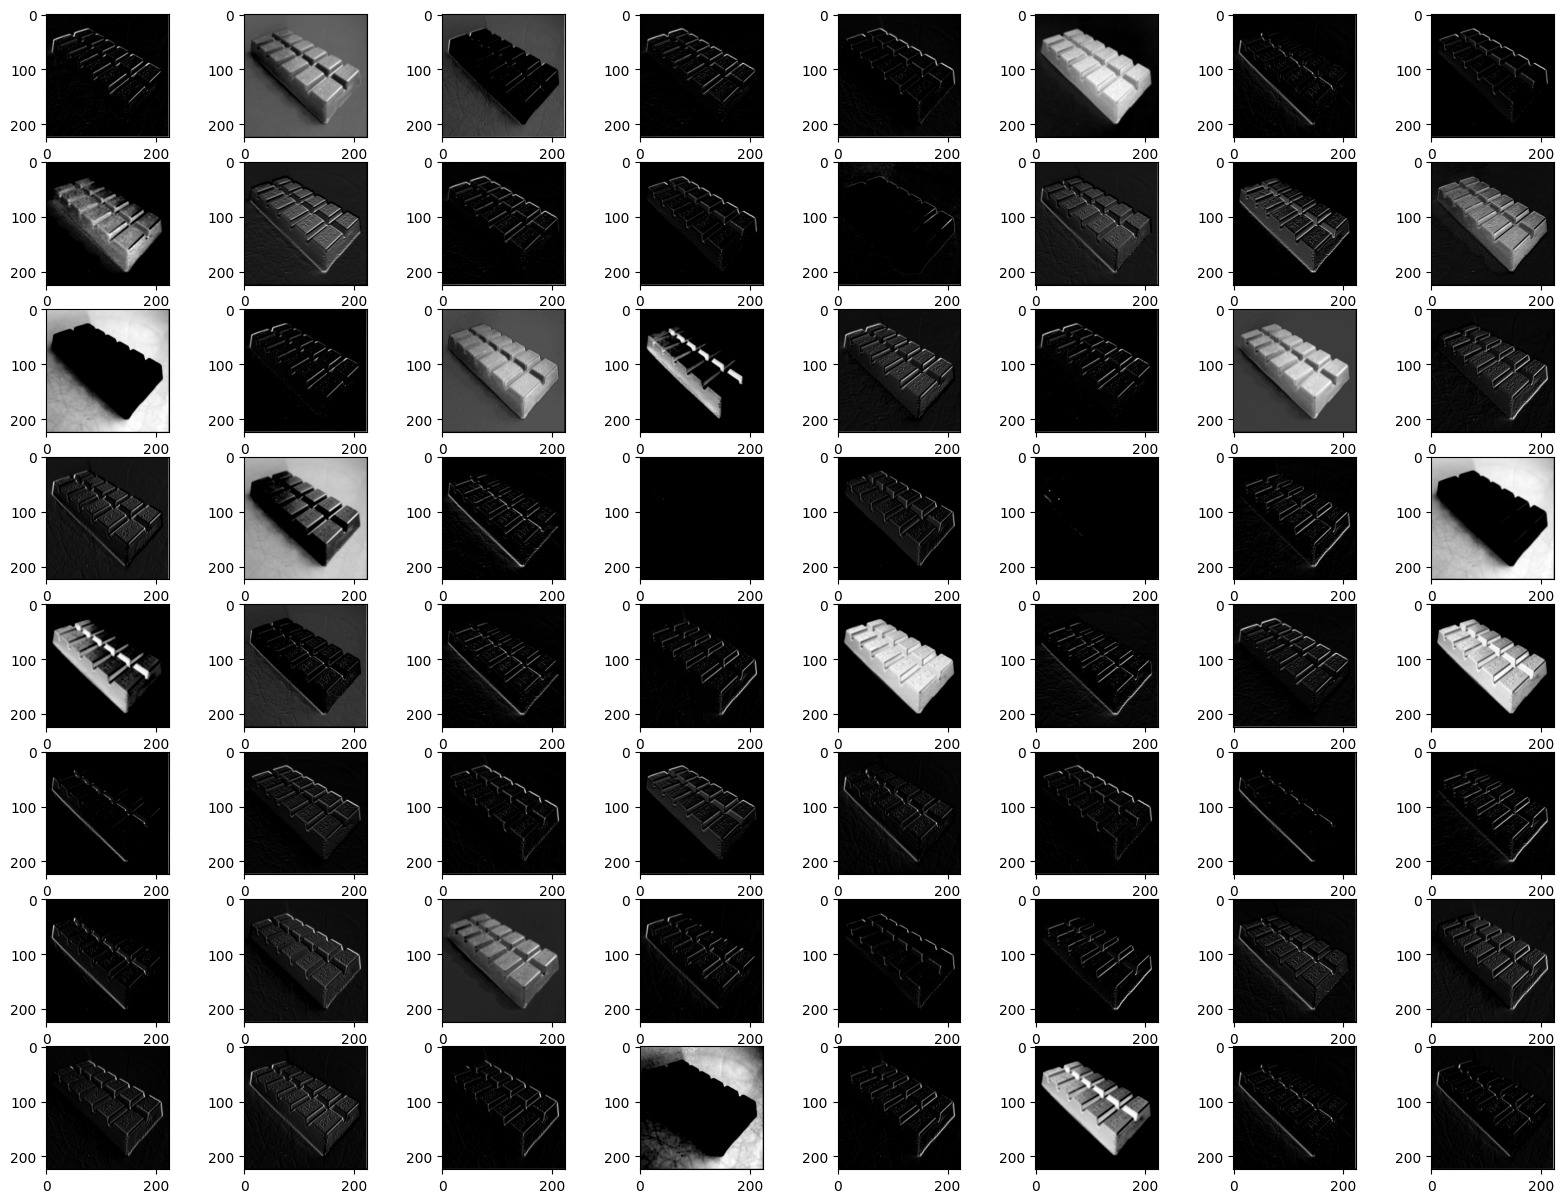

In [ ]:
#Finding the feature map
fmap = new_model.predict(new_img)

print(fmap.shape)

fig = pyplot.figure(figsize=(20,15))
for i in range(1,features.shape[3]+1):

    pyplot.subplot(8,8,i)
    pyplot.imshow(fmap[0,:,:,i-1] , cmap='gray')

pyplot.show()

In [ ]:
label=vgg16_mod.predict(new_img)

# Decode and top 10 predicted classes
decoded_predictions = decode_predictions(label, top=10)[0]
for i, (imagenet_id, label, score) in enumerate(decoded_predictions):
    print(f"{i + 1}: {label} ({score:.2f})")

# Get the top predicted class
top_prediction = decoded_predictions[0][1]
print("Top Prediction:", top_prediction)

1/1 [==============================] - 0s 20ms/step
1: computer_keyboard (0.48)
2: space_bar (0.17)
3: typewriter_keyboard (0.06)
4: mouse (0.06)
5: joystick (0.03)
6: remote_control (0.03)
7: switch (0.02)
8: combination_lock (0.02)
9: modem (0.01)
10: dumbbell (0.01)
Top Prediction: computer_keyboard


# Part 7: Retraining of VGG16 ON MNIST DATASET

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Load and preprocess the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print(train_images.shape)
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255.0
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255.0


train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# Load the pre-trained VGG16 model without the top layers
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

(60000, 28, 28)


In [ ]:
# Freeze the layers of the pre-trained VGG16 model
i=0
for layer in base_model.layers:
  i=i+1
  print(i)
  if i<4:
    continue
  else:
    print("false")
    layer.trainable = False

1
2
3
4
false
5
false
6
false
7
false
8
false
9
false
10
false
11
false
12
false
13
false
14
false
15
false
16
false
17
false
18
false
19
false


In [ ]:
from tensorflow.keras.layers import Layer

class ResizeLayer(Layer):
    def __init__(self, target_size=(32, 32), **kwargs):
        super(ResizeLayer, self).__init__(**kwargs)
        self.target_size = target_size

    def call(self, inputs, **kwargs):
        # Resize the image to the target size
        resized_image = tf.image.resize(inputs, self.target_size)

        # Expand dimensions to mimic RGB channels
        inputs = tf.expand_dims(inputs, axis=-1)

        # Duplicate the channel dimension to mimic RGB
        resized_image = tf.tile(resized_image, [1, 1, 1, 3])

        return resized_image

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.target_size[0], self.target_size[1], 3

In [ ]:
#Defining a new model with a first layer to resize the input images
new_model=models.Sequential()
new_model.add(ResizeLayer([32,32]))
new_model.add(base_model)
new_model.add(layers.Flatten())
new_model.add(layers.Dense(10,activation='softmax'))


In [ ]:
# Compile the model
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
new_model.fit(train_images, train_labels, epochs=2, batch_size=64, validation_data=(test_images, test_labels))

Epoch 1/2
899/938 [===========================>..] - ETA: 3:11 - loss: 0.3177 - accuracy: 0.9055

KeyboardInterrupt: 

In [ ]:
i=0
for layer in new_model.layers:
    i=i+1
    print(i , layer.name , layer.output.shape)

1 resize_layer_9 (None, 32, 32, 3)
2 vgg16 (None, 1, 1, 512)
3 flatten_2 (None, 512)
4 dense_4 (None, 10)


In [ ]:
# Load the pre-trained VGG16 model without the top layers
orig_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

In [ ]:
l=new_model.get_layer('vgg16')
l.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [ ]:
for layer,new in zip(orig_model.layers,l.layers):
    #j+=1
    count=0
    if 'conv' not in layer.name:
        continue

    filters , bias = layer.get_weights()
    new_f,new_b=new.get_weights()
    #print(layer.name , filters.shape)
    #print("New")
    #print(new.name , new_f.shape)

    if j<2:
      for i in range(64):
        #print("enter")
        f=filters[:,:,:,i]
        n_f=new_f[:,:,:,i]
        #if i<2:
          #print(f)
          #print(n_f)
        if (f!=n_f).all():
          #print("true")
          count+=1
        #if .any()!=new_f[:,:,:i].any():
        #count+=1

        #if i<2:
          #print(f.shape)
    print("Change filters in ", layer.name,": ", count)


Change filters in  block1_conv1 :  64
Change filters in  block1_conv2 :  64
Change filters in  block2_conv1 :  0
Change filters in  block2_conv2 :  0
Change filters in  block3_conv1 :  0
Change filters in  block3_conv2 :  0
Change filters in  block3_conv3 :  0
Change filters in  block4_conv1 :  0
Change filters in  block4_conv2 :  0
Change filters in  block4_conv3 :  0
Change filters in  block5_conv1 :  0
Change filters in  block5_conv2 :  0
Change filters in  block5_conv3 :  0
